# Writing a modal solver #


Import fenics, pyplot, numpy, petsc4py and a timer for modal analysis and testing

In [1]:
from fenics import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import petsc4py

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

The example problem used is the linear Poisson equation. We compute the solution to this using a linear solver for reference.

In [2]:
def linear_solve(a, L, uh, bcs): 
    A = assemble(a)
    b = assemble(L) 
    for bc in bcs:
        bc.apply(A, b) 
    x = uh.vector() 
    solve(A, x, b)
    return x

The linear solver is applied on the Poisson equation and we get the following result:

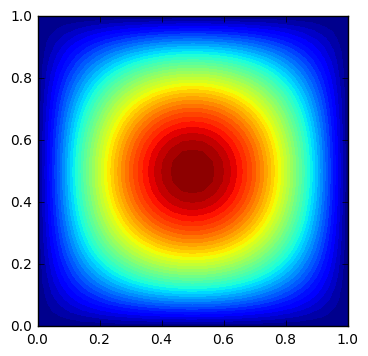

In [3]:
h = 32
mesh = UnitSquareMesh(h, h)   # generate mesh
V = FunctionSpace(mesh, 'P', 1)    # create finite element function space V, based on linear Lagrange elements
# plot(mesh)

f_exp = Expression('2*pi*pi * sin(pi*x[0]) * sin(pi*x[1])', degree=4)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

# Define boundary conditions
u_D = Expression('sin(pi*x[0]) * sin(pi*x[1])', degree=4)
bc = [DirichletBC(V, u_D, boundary)]

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(grad(u), grad(v))*dx
L = f_exp * v * dx

# Compute solution
uref = Function(V)
uref.vector()[:] = linear_solve(a, L, uref, bc)
plot(uref)
plt.show()

# Modal analysis

For modal analysis we need to compute the modes by solving the eigenvalue problem. The eigenvalue problem is reduced to the submatrix excluding the degrees of freedom on the Dirichlet boundary. Using the reduced set ensures there are no spurious eigenvectors due to Dirichlet boundary conditions.

$$
\left( \mathbf{A} - \lambda \mathbf{I} \right) \phi = \mathbf{0}, \qquad \text{on: } \Omega_{red} \\
\Omega_{red} \subset \Omega \\
\Omega_{red} \setminus \Gamma_D
$$

The eigensolver starts by looking for the smallest magnitude eigenvalues, these values correspond to the smallest natural frequencies which are the modes with the most global shapes.

The spectral shift is at 10, which is a recommended value so that we will find converged solutions but I am not sure why. This is also something to play around with in case the problem does not converge.

After the eigensolver has computed the modes, the algorithm collects the mode vectors and eigenvalues in a list. The modal vectors need to be projected from the reduced space $\Omega_{red}$ to the full space $\Omega$.


In [4]:
def extract_modes(A, bcs, neigs):
        
    index_set_not_bc = get_interior_index_set(bcs, V)
    A_reduced = reduce_matrix(A, index_set_not_bc)
    
    solver = SLEPcEigenSolver(A_reduced)
    solver.parameters["spectrum"] = "smallest magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    solver.parameters["spectral_shift"] = 10.
    solver.solve(neigs)
    
    n_modes_converged = solver.get_number_converged()
    
    # Extract and plot modes
    modes=[]
    eigvalues=[]
    vtkfile = File('Modes/modes.pvd')  
    for md in range(n_modes_converged):
        r, c, rx, cx = solver.get_eigenpair(md)
        # Project reduced eigenvector back to full function space
        eigenfunction = Function(V, name="eigenmode")
        eigenfunction_backend = project_to_full_space(rx, eigenfunction, index_set_not_bc)

        eigenfunction.vector().zero()
        eigenfunction.vector().axpy(1, eigenfunction_backend)
        
        modes.append(eigenfunction)
        eigvalues.append(r)
        # Save mode to file
        vtkfile << (eigenfunction, r)  
    return modes, eigvalues

The following auxilliary functions are used to compute modes: a function to get the indices of the reduced domain, setting up of the reduced matrix, projecting a vector from the reduced space to the full space. 

These functions have been taken from a [demo in fenics-shells](https://bitbucket.org/unilucompmech/fenics-shells/src/02430de5b069568cd251cb86d82bb80ffd5b1660/demo/undocumented/kirchhoff_love/demo_kirchhoff-love-laminate-cantilever-free-vibration.py?at=master&fileviewer=file-view-default).

In [5]:
# functions taken from fenics-shells example:
# https://bitbucket.org/unilucompmech/fenics-shells/src/02430de5b069568cd251cb86d82bb80ffd5b1660/demo/undocumented/kirchhoff_love/demo_kirchhoff-love-laminate-cantilever-free-vibration.py?at=master&fileviewer=file-view-default


# Function to get indices of submatrix unaffected by BCs
def get_interior_index_set(boundary_conditions, function_space):
    # Set bcs to a list if necessary
    if type(boundary_conditions) == dolfin.fem.bcs.DirichletBC:
        boundary_conditions = [boundary_conditions]
    # Find DOFs affected by the boundary conditions
    bc_dofs = []
    for bc in boundary_conditions:
        bc_dofs.extend(bc.get_boundary_values().keys())
    ownership_range = function_space.dofmap().ownership_range()
    interior_dofs = [x for x in range(ownership_range[0], ownership_range[1]) if x not in bc_dofs]
    # Create petsc4py.PETSc.IS object with interior degrees of freedom
    index_set = petsc4py.PETSc.IS()
    index_set.createGeneral(interior_dofs)
    return index_set


# Get the reduced matrix
def reduce_matrix(matrix, index_set):
    sub_matrix = matrix.mat().getSubMatrix(index_set, index_set)
    return dolfin.cpp.la.PETScMatrix(sub_matrix)


# Project vector from reduced DoF basis to full domain
def project_to_full_space(vector, full_function, index_set):
    # Set up full vector
    full_function_backend = dolfin.cpp.la.as_backend_type(full_function.vector()).vec()
    reduced_function_backend = full_function_backend.getSubVector(index_set)
    projector = petsc4py.PETSc.Scatter()
    projector.create(
        vec_from=reduced_function_backend,
        is_from=None,
        vec_to=full_function_backend,
        is_to=index_set)
    
    result_function = full_function.copy(deepcopy=True)
    result_backend = as_backend_type(result_function.vector()).vec()
    projector.scatter(vec_from=vector.vec(), vec_to=result_backend)
    result_backend.ghostUpdate()
    return dolfin.cpp.la.PETScVector(result_backend)

### Modal analysis using stiffness matrices ###
The "stiffness" of the problem is given as the matrix $\mathbf{A}$ that is calculated over the domain using a function that integrates over the domain. This way the modal stiffness matrix of the domain is contructed using the mode shapes directly.

The problem is solved by:
* assembling the system in a PETSc matrix
* reducing the problem to only take the interior domain into account
* extracting the eigenpairs of the left hand side and projection on the full domain
* construction of modal "stiffness" and force matrix
* the solution is found by solving algebraically

In [6]:
# Define modal variational problem
u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = f_exp * v * dx

# Get eigenvalues, modes and coefficients (should be rewritten for dynamic case)
neigs = 40
uh = Function(V)

# set up matrices and assemble systen
A = PETScMatrix()
b = PETScVector()
assemble_system(a, L, bc, A_tensor=A, b_tensor=b)

(<dolfin.cpp.la.PETScMatrix; proxy of <Swig Object of type 'std::shared_ptr< dolfin::PETScMatrix > *' at 0x7efc35c8c990> >,
 <dolfin.cpp.la.PETScVector; proxy of <Swig Object of type 'std::shared_ptr< dolfin::PETScVector > *' at 0x7efc35c8c5d0> >)

The modes are extracted in the modal solver where the details of the modal solver itself are quite complicated but the way we can apply it is relatively simple:

In [7]:
# Extract modes and set up modal matrices
modes, evs = extract_modes(A, bc, neigs)

The modal stiffness and force is projected by using a numpy dot multiplication.

In [8]:

nmodes = len(evs)
l_vec = len(modes[0].vector().array())
mode_array = np.zeros((l_vec, nmodes))
for i in range(nmodes):
    mode_array[:, i] = modes[i].vector().array()

F = np.dot(mode_array.T, b.array())
K = np.dot(np.dot(mode_array.T, A.array()), mode_array)

#### Compare to reference solution ####
In the current case we are looking at a static problem, therefore we only use the stiffness matrix K in our analysis. This leads to the following problem on the modal basis:

$$
\mathbf{K}_m \mathbf{c}_n = \mathbf{f}_m
$$

Which can easily be solved by 
$$
\mathbf{c}_n = \mathbf{K}_m^{-1} \mathbf{f}_m
$$

We will now try to find the modes based on the Jacobian in this notebook.

[]

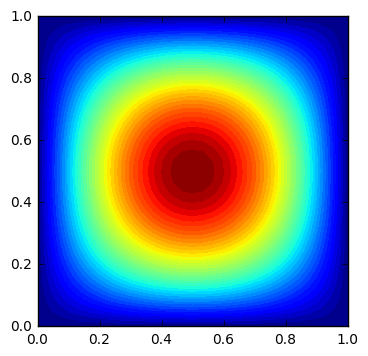

In [9]:
# Calculate the static coefficients
c_0 = np.linalg.solve(K, F)

uh = Function(V)
for i in range(nmodes):
    uh.vector()[:] += mode_array[:, i] * c_0[i]

plt.figure()
plot(uh)
plt.plot()

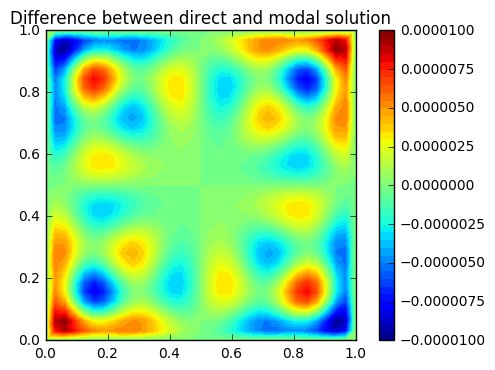

In [10]:

plt.figure()
plt.title("Difference between direct and modal solution")
ax = plot(uref - uh)
cbar = plt.colorbar(ax)
plt.show()

In [11]:
print("Norm between the reference and modal vector: ")
print(norm(uh.vector() - uref.vector()))
print("")
print("Relative norm")
print(norm(uh.vector() - uref.vector())/ norm(uh.vector()))

Norm between the reference and modal vector: 
9.5025988362e-05

Relative norm
5.94389598732e-06
